<a href="https://colab.research.google.com/github/hydro-7/Cat_v_Dog_Classification/blob/main/Cat_v_Dog_RESNET18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dog vs Cat Classification**

Step 1 : Get the Cats vs Dogs dataset from kaggle.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hydro7","key":"b77069e6f4d8eaf633db009b9fe4da71"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Aug 10 18:04 kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!pwd

/content


In [10]:
!kaggle datasets list

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadehsan000/2024-electric-car-data-washington-state   Electric Vehicle Data (1997 - 2024)                  6MB  2024-08-04 10:33:24           1146         31  1.0              
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           3080         45  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020      Olympic Historical Dataset (1896 - 2022)            27MB  2024-08-06 16:46:08           1787         31  1.0              
waqi786/heart-attack-dataset                               ❤️ Heart Attack Risk Factors Da

In [11]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:21<00:00, 42.3MB/s]
100% 812M/812M [00:21<00:00, 39.9MB/s]


In [12]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [13]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [14]:
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

Step 2 : Import stuff


In [15]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import shutil

import requests
import zipfile
from pathlib import Path
from torch.utils.data import random_split

seed = 42

Step 3 : Print a random image to check if connection to folder is proper

In [16]:
image_path = Path("train")

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print("Khel khatam")

train directory exists.


Image class: dog


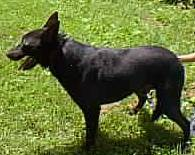

In [17]:
import random
from PIL import Image

random.seed(seed)

image_path_list = list(image_path.glob("*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.name.split(".")[0]

img = Image.open(random_image_path)


print(f"Image class: {image_class}")

img

Step 4 : Image Augumentation

In [18]:
data_transform = transforms.Compose([  transforms.Resize(size=(64, 64))  , transforms.RandomHorizontalFlip(p=0.5)  , transforms.ToTensor() ,  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [19]:
# Alternative Data augumentation step
# mean = [0.463, 0.428, 0.3291]
# std = [0.2129, 0.2075, 0.2038]

# data_transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.RandomHorizontalFlip(p=0.5)
#     transforms.RandomRotation(degrees=10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)
# ])

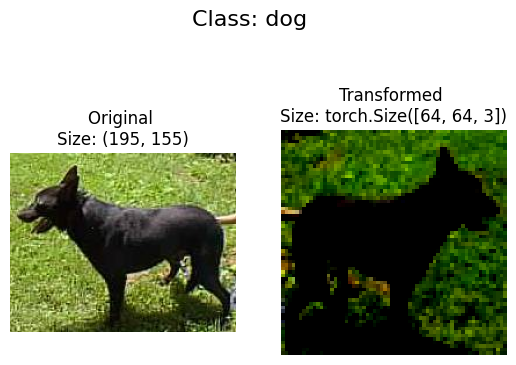

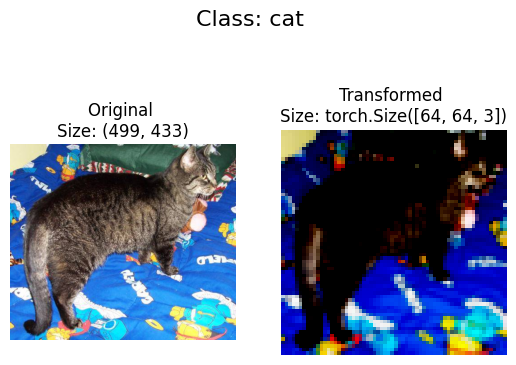

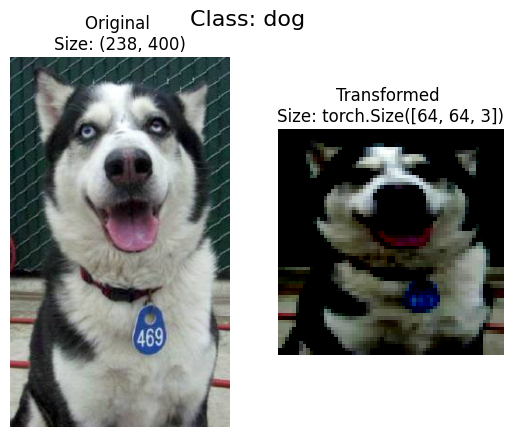

In [20]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            str1 = image_path.name.split(".")[0]
            fig.suptitle(f"Class: {str1}", fontsize=16)


plot_transformed_images(image_path_list,  transform=data_transform,  n=3)

Step 5 : Split the images into Cat & Dog folders

In [21]:
train_folder = 'train'
cf = 'cats'
df = 'dogs'

In [22]:
cats_folder = os.path.join(train_folder, cf)

os.makedirs(cats_folder, exist_ok=True)

In [23]:
dogs_folder = os.path.join(train_folder, df)

os.makedirs(dogs_folder, exist_ok=True)

In [24]:
for source_path in image_path_list:
    image_class = source_path.name.split(".")[0]
    if image_class == "cat":
        destination_path = cats_folder
    else:
        destination_path = dogs_folder
    shutil.move(source_path, destination_path)

In [25]:
dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=data_transform)
print(dataset.class_to_idx)
idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}

{'cats': 0, 'dogs': 1}


Step 6 : Split into train & validate dataset


In [26]:
# data_size = len(dataset)
# train_dataset, validation_dataset = random_split(dataset, [int(0.8 * data_size), int(0.2 * data_size)])

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [27]:
# for value in train_dataloader:
#     data, label = value
#     print(data.shape)
#     print(f"This is a {idx_to_class[int(label.item())]}")
#     plt.imshow(torch.squeeze(data).permute(1, 2, 0))
#     break

In [28]:
data_size = len(dataset)
train_dataset, validation_dataset = random_split(dataset, [int(0.8 * data_size), int(0.2 * data_size)])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Step 7 : Let the games begin

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Step 8 : Defining the CNN Model : Resnet 18 architecture

In [30]:
# train_dataset, validation_dataset, train_dataloader, validation_dataloader

In [31]:
def train_nn(model, train_dataloader, validation_dataloader, loss_fn, optimizer, n_epochs):
  print("Training the model")
  for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for data in train_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        total += labels.size(0)

        optimizer.zero_grad()

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        running_correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = 100.0 * running_correct / total

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

    evaluate_model_on_validation_set(model, validation_dataloader)

  print("finished")
  return model

In [32]:
# def evaluate_model_on_validation_set(model, validation_data):


def evaluate_model_on_validation_set(model, validation_dataloader):
  print("Evaluating the model")
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      total += labels.size(0)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      predicted_correctly_on_epoch += (predicted == labels).sum().item()
  epoch_acc = 100.0 * predicted_correctly_on_epoch / total

  print(f"Validation Acc: {epoch_acc:.2f}%")

In [33]:
# renet18_model = models.resnet18(pretrained=True) # if we wish to use the pretrained model
resnet18_model = models.resnet18(pretrained=False) # starts with random weights, to make from scratch

num_ftrs = resnet18_model.fc.in_features
number_of_classes = 2

resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes) # prepares the req matrices for forward propogation
resnet18_model = resnet18_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 0.003) # Stochastic gradient descent, and if you specify the batch size, it will apply mini batch gradient descent algorithm for you
# optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001) # Adam optimizer
# lr = learning rate, try 0.01 & 0.001
# momentum helps accelerate the descent
# weight decay helps prevent overfitting

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
train_nn(resnet18_model, train_dataloader, validation_dataloader, loss_fn, optimizer, 30)

Training the model
Epoch 1
Train Loss: 0.6956, Train Acc: 63.42%
Evaluating the model
Validation Acc: 73.26%
Epoch 2
Train Loss: 0.5292, Train Acc: 74.14%
Evaluating the model
Validation Acc: 75.54%
Epoch 3
Train Loss: 0.4424, Train Acc: 79.69%
Evaluating the model
Validation Acc: 82.74%
Epoch 4
Train Loss: 0.3995, Train Acc: 81.84%
Evaluating the model
Validation Acc: 83.84%
Epoch 5
Train Loss: 0.3645, Train Acc: 83.78%
Evaluating the model
Validation Acc: 82.70%
Epoch 6
Train Loss: 0.3398, Train Acc: 85.08%
Evaluating the model
Validation Acc: 85.06%
Epoch 7
Train Loss: 0.3250, Train Acc: 85.96%
Evaluating the model
Validation Acc: 83.76%
Epoch 8
Train Loss: 0.3155, Train Acc: 86.22%
Evaluating the model
Validation Acc: 86.00%
Epoch 9
Train Loss: 0.3070, Train Acc: 86.53%
Evaluating the model
Validation Acc: 83.10%
Epoch 10
Train Loss: 0.2982, Train Acc: 87.39%
Evaluating the model
Validation Acc: 84.94%
Epoch 11
Train Loss: 0.2887, Train Acc: 87.56%
Evaluating the model
Validation A

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  